In [1]:
import torch
import torch.nn as tnn
import torch_geometric.nn as gnn
from torch_geometric.datasets import KarateClub, TUDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

root = './dataset/enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset= TUDataset('./dataset/enzymes', 'ENZYMES')
# You can find that there are 600 graphs in this dataset
print(pyg_dataset)

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Get the first graph object

ENZYMES(600)


Extracting dataset/enzymes/ENZYMES/ENZYMES.zip
Processing...
Done!


In [2]:
class GCN_sq(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        
        self.GCN_layers = gnn.Sequential('x, edge_index', [
            (gnn.GCNConv(dataset.num_features, 16), 'x, edge_index -> x'),
            (F.relu, 'x -> x'),
            (F.dropout, 'x -> x'),
            (gnn.GCNConv(16, dataset.num_classes), 'x, edge_index -> x')
        ])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.GCN_layers(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = gnn.GCNConv(dataset.num_features, 16)
        self.conv2 = gnn.GCNConv(16, 32)
        self.mlp1 = tnn.Linear(32, 16)
        self.mlp2 = tnn.Linear(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.mlp1(x)
        x = F.relu(x)
        x = self.mlp2(x)

        return F.log_softmax(x, dim=1)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Instantiate the model and optimizer
model = GCN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [23]:
# Training loop
model.train()
data.to(device)
for epoch in range(100000):
    optimizer.zero_grad()
    out = model.forward(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Accuracy: 0.5882


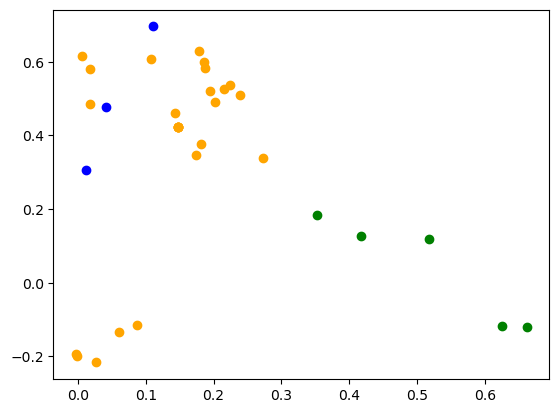

In [26]:
import matplotlib.pyplot as plt
import numpy as np

num_nodes = data.num_nodes  # Get the number of nodes
test_mask = torch.zeros(num_nodes, dtype=torch.bool)  # Create a mask of all zeros
test_mask[:] = 1  # Set the last 20% of the mask to 1
data.test_mask = test_mask  # Add the test mask to the data object


# Switch model to evaluation mode
model.eval()

# Make predictions
_, pred = model(data).max(dim=1)

# Calculate accuracy
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

# # Visualization
colors = ['orange', 'blue', 'green']

# Get the embeddings of the graph
embeddings = model.conv1(data.x, data.edge_index).detach().cpu().numpy()

# Create a scatter plot
for i in range(dataset.num_classes):
    class_indices = (pred == i).detach().cpu().nonzero().numpy().flatten()
    plt.scatter(embeddings[class_indices, 0], embeddings[class_indices, 1], color=colors[i % len(colors)])

plt.show()
